# Results Figure 1 (Binary Experiment)

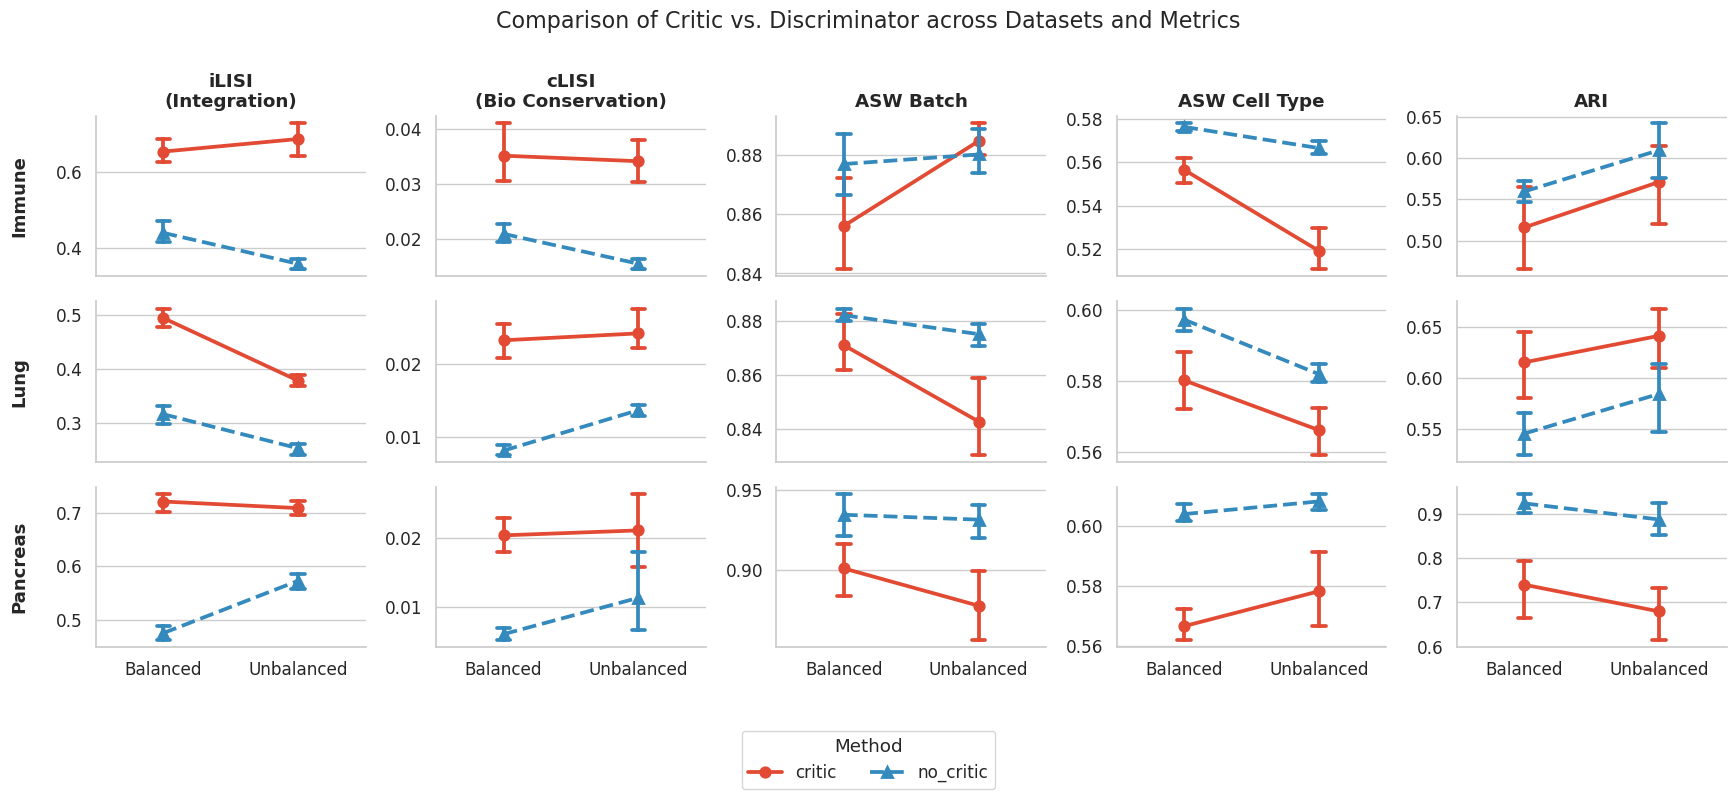

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Data Preparation (Loading Real Data) ---

# Define the root path where your 'scripts' folder is located.
# Assuming you run this from the project root (where 'scripts' is a subdirectory):
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments"

# Define the structure of your experiments
conditions = ["balanced", "unbalanced"]
datasets = ["immune", "lung", "pancreas"]

data_frames = []

for cond in conditions:
    for ds in datasets:
        # Construct the file path based on your directory structure
        # Example: ./scripts/binary_experiments/unbalanced/immune_final_best_results.csv
        file_path = os.path.join(base_dir, cond, f"{ds}_final_best_results.csv")
        
        if os.path.exists(file_path):
            try:
                # Read the CSV file
                df = pd.read_csv(file_path)
                
                # Add the metadata columns that aren't in the CSV
                df['dataset'] = ds.capitalize()    # 'immune' -> 'Immune'
                df['condition'] = cond.capitalize() # 'balanced' -> 'Balanced'
                
                data_frames.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"Warning: File not found at {file_path}")

if not data_frames:
    raise FileNotFoundError("No result files were found. Please check the 'base_dir' path.")

# Combine all loaded data into one DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)

# --- 2. Transform Data for Plotting ---

# Melt the DataFrame to long format for Seaborn
long_df = combined_df.melt(
    id_vars=['dataset', 'condition', 'method', 'fold'],
    value_vars=['ilisi', 'clisi', 'asw_batch', 'asw_celltype', 'ari'],
    var_name='metric_type',
    value_name='score'
)

# Rename metrics for cleaner plot labels
metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)',
    'asw_batch': 'ASW Batch',
    'asw_celltype': 'ASW Cell Type',
    'ari': 'ARI'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# --- 3. Create the Visualization ---

sns.set_theme(style="whitegrid", font_scale=1.1)

g = sns.catplot(
    data=long_df,
    x="condition",
    y="score",
    hue="method",
    col="metric_type",
    row="dataset",
    kind="point",
    errorbar=("ci", 95),
    palette={"critic": "#E24A33", "no_critic": "#348ABD"},
    height=2.5,
    aspect=1.3,
    sharey=False, 
    sharex=True,
    markers=["o", "^"],
    linestyles=["-", "--"],
    capsize=0.1,
    margin_titles=False
)

# --- 4. Customizing Labels and Titles ---

# A. Clear default axis labels
g.set_axis_labels("", "")

# B. Clear auto-generated titles
g.set_titles(row_template="", col_template="")

# C. Manual Axis Manipulation Loop
for i, row_axes in enumerate(g.axes):
    for j, ax in enumerate(row_axes):
        
        # --- Handle Row Labels (Dataset Names) on far left Y-axis ---
        if j == 0:
             # This uses the row_names derived from the 'dataset' column
             ax.set_ylabel(g.row_names[i], fontweight='bold', fontsize=13, labelpad=20)

        # --- Handle Column Titles (Metric Names) ---
        if i == 0:
            # TOP ROW: Set title manually using the clean list from seaborn
            clean_title = g.col_names[j]
            ax.set_title(clean_title, fontweight='bold')
        else:
            # NOT TOP ROW: Ensure title is empty
            ax.set_title("")

# --- 5. Final Polish ---

g.fig.suptitle("Comparison of Critic vs. Discriminator across Datasets and Metrics", y=1.0, fontsize=16)

# Move legend down
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.05), ncol=2, title="Method", frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()

# Results Figure 2 (muli-batch scaling)

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/multibatch_experiments for results...


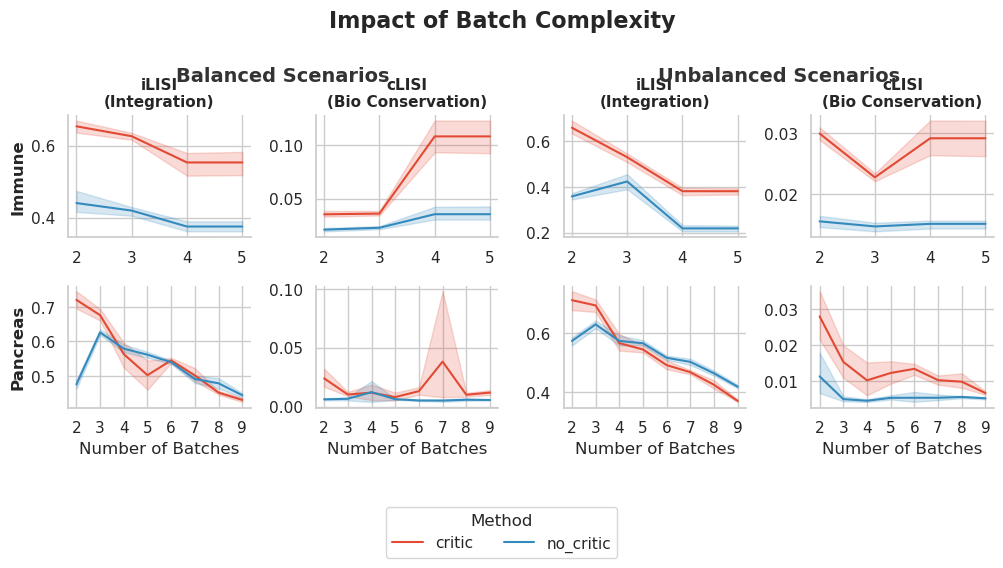

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MaxNLocator

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/multibatch_experiments"
data_frames = []

print(f"Scanning {base_dir} for results...")

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("_final_best_results.csv"):
            file_path = os.path.join(root, file)
            parts = file_path.split(os.sep)
            try:
                # Path structure: .../condition/dataset_group/batch_dir/filename
                batch_folder = parts[-2]
                condition = parts[-4]
                n_batches = int(batch_folder.split('_')[-1])
                
                if "immune" in batch_folder: dataset_name = "Immune"
                elif "panc" in batch_folder: dataset_name = "Pancreas"
                else: dataset_name = "Unknown"

                df = pd.read_csv(file_path)
                df['condition'] = condition.capitalize()
                df['dataset'] = dataset_name
                df['n_batches'] = n_batches
                data_frames.append(df)
            except Exception as e:
                pass

if not data_frames:
    raise FileNotFoundError("No result files found.")

combined_df = pd.concat(data_frames, ignore_index=True)

# --- 2. Data Preparation ---
long_df = combined_df.melt(
    id_vars=['dataset', 'condition', 'n_batches', 'method', 'fold'],
    value_vars=['ilisi', 'clisi'],
    var_name='metric_type',
    value_name='score'
)

metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# Grouping for 4 columns
long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']
col_order = [
    f"Balanced\n{metric_renames['ilisi']}", 
    f"Balanced\n{metric_renames['clisi']}",
    f"Unbalanced\n{metric_renames['ilisi']}", 
    f"Unbalanced\n{metric_renames['clisi']}"
]

# --- 3. Plotting ---
sns.set_theme(style="whitegrid", font_scale=1.0)

g = sns.relplot(
    data=long_df,
    x="n_batches",
    y="score",
    hue="method",
    col="panel_group",
    row="dataset",
    col_order=col_order,
    kind="line",
    markers=True,
    dashes=False,
    errorbar=("ci", 95),
    palette={"critic": "#E24A33", "no_critic": "#348ABD"},
    height=2.5,
    aspect=0.9,
    facet_kws={"sharey": False, "sharex": "row"} 
)

# --- 4. Customization ---

# A. BRUTE FORCE CLEAR ALL TITLES (Fixes the "|" issue)
for ax in g.axes.flatten():
    ax.set_title("")

# B. Manually set top row titles only
clean_titles = [
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)", 
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)"
]

for ax, title in zip(g.axes[0], clean_titles):
    ax.set_title(title, fontweight='bold', fontsize=11)

# C. Set Dataset Labels on Y-axis
g.set_axis_labels("Number of Batches", "")
for i, row_name in enumerate(g.row_names):
    g.axes[i, 0].set_ylabel(row_name, fontweight='bold', fontsize=12)

# D. Integer Ticks
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.0), ncol=2, title="Method", frameon=True)

# --- 5. Group Subtitles ---

g.fig.tight_layout(rect=[0, 0.05, 1, 0.88]) 

def add_group_subtitle(g, col_indices, text, y_offset=0.06):
    ax_left = g.axes[0, col_indices[0]]
    ax_right = g.axes[0, col_indices[-1]]
    bbox_left = ax_left.get_position()
    bbox_right = ax_right.get_position()
    center_x = (bbox_left.x0 + bbox_right.x1) / 2
    center_y = bbox_left.y1 + y_offset
    g.fig.text(center_x, center_y, text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

add_group_subtitle(g, [0, 1], "Balanced Scenarios")
add_group_subtitle(g, [2, 3], "Unbalanced Scenarios")

g.fig.suptitle("Impact of Batch Complexity", y=0.98, fontsize=16, fontweight='bold')

plt.savefig("multibatch_trends_grouped.png", dpi=300, bbox_inches='tight')
plt.show()

# Results Figure 3 (Reference Batch)

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/reference_experiments for results...


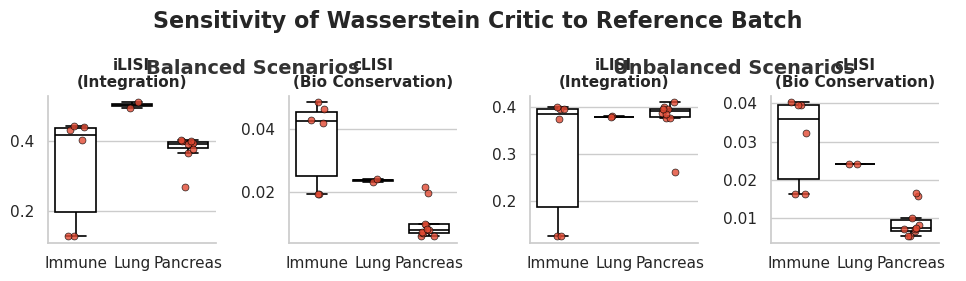

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/reference_experiments"
data_frames = []

print(f"Scanning {base_dir} for results...")

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("_final_best_results.csv"):
            file_path = os.path.join(root, file)
            parts = file_path.split(os.sep)
            try:
                # Path structure: .../condition/dataset_group/dataset_refIndex/filename
                batch_folder = parts[-2]
                dataset_group = parts[-3]
                condition = parts[-4]
                
                ref_index = int(batch_folder.split('_')[-1])
                
                if "immune" in dataset_group: dataset_name = "Immune"
                elif "lung" in dataset_group: dataset_name = "Lung"
                elif "panc" in dataset_group: dataset_name = "Pancreas"
                else: dataset_name = "Unknown"

                df = pd.read_csv(file_path)
                df['condition'] = condition.capitalize()
                df['dataset'] = dataset_name
                df['ref_index'] = ref_index
                
                data_frames.append(df)
            except Exception as e:
                pass

if not data_frames:
    raise FileNotFoundError("No result files found.")

combined_df = pd.concat(data_frames, ignore_index=True)

# --- 2. Filter for CRITIC ONLY ---
critic_df = combined_df[combined_df['method'] == 'critic'].copy()

# Average across folds (one point per Reference Batch)
agg_df = critic_df.groupby(
    ['dataset', 'condition', 'ref_index']
)[['ilisi', 'clisi']].mean().reset_index()

# Melt for plotting
long_df = agg_df.melt(
    id_vars=['dataset', 'condition', 'ref_index'],
    value_vars=['ilisi', 'clisi'],
    var_name='metric_type',
    value_name='score'
)

metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# Grouping
long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']
col_order = [
    f"Balanced\n{metric_renames['ilisi']}", 
    f"Balanced\n{metric_renames['clisi']}",
    f"Unbalanced\n{metric_renames['ilisi']}", 
    f"Unbalanced\n{metric_renames['clisi']}"
]

# --- 3. Plotting ---
sns.set_theme(style="whitegrid", font_scale=1.0)

# We define a single color for the critic since we aren't comparing methods anymore
critic_color = "#E24A33" 

g = sns.catplot(
    data=long_df,
    x="dataset",
    y="score",
    col="panel_group",
    col_order=col_order,
    kind="box",
    color="white",    # White box background
    linecolor="black", # Black outline
    height=3.0,
    aspect=0.8,
    sharey=False,
    sharex=True,
    fliersize=0,      # Hide outliers
    linewidth=1.2,
    gap=0.1,
    native_scale=True # Better x-axis handling
)

# Overlay individual points (Stripplot)
for i, ax in enumerate(g.axes.flatten()):
    panel_name = col_order[i]
    panel_data = long_df[long_df['panel_group'] == panel_name]
    
    sns.stripplot(
        data=panel_data,
        x="dataset",
        y="score",
        ax=ax,
        color=critic_color, # Use the specific Critic color
        alpha=0.8,
        jitter=0.15,
        size=5,
        edgecolor="black",  # Add a tiny border to dots for clarity
        linewidth=0.5
    )

# --- 4. Customization ---

# Clear default titles
g.set_titles("")
g.set_axis_labels("", "")

# Metric Titles (Top Row)
clean_titles = [
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)", 
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)"
]
for ax, title in zip(g.axes[0], clean_titles):
    ax.set_title(title, fontweight='bold', fontsize=11)

# Group Subtitles
g.fig.tight_layout(rect=[0, 0.05, 1, 0.88]) 

def add_group_subtitle(g, col_indices, text, y_offset=0.06):
    ax_left = g.axes[0, col_indices[0]]
    ax_right = g.axes[0, col_indices[-1]]
    bbox_left = ax_left.get_position()
    bbox_right = ax_right.get_position()
    center_x = (bbox_left.x0 + bbox_right.x1) / 2
    center_y = bbox_left.y1 + y_offset
    g.fig.text(center_x, center_y, text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

add_group_subtitle(g, [0, 1], "Balanced Scenarios")
add_group_subtitle(g, [2, 3], "Unbalanced Scenarios")

g.fig.suptitle("Sensitivity of Wasserstein Critic to Reference Batch", y=0.98, fontsize=16, fontweight='bold')

plt.savefig("reference_sensitivity_critic_only.png", dpi=300, bbox_inches='tight')
plt.show()

# Results Figure 4

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments for sensitivity records...


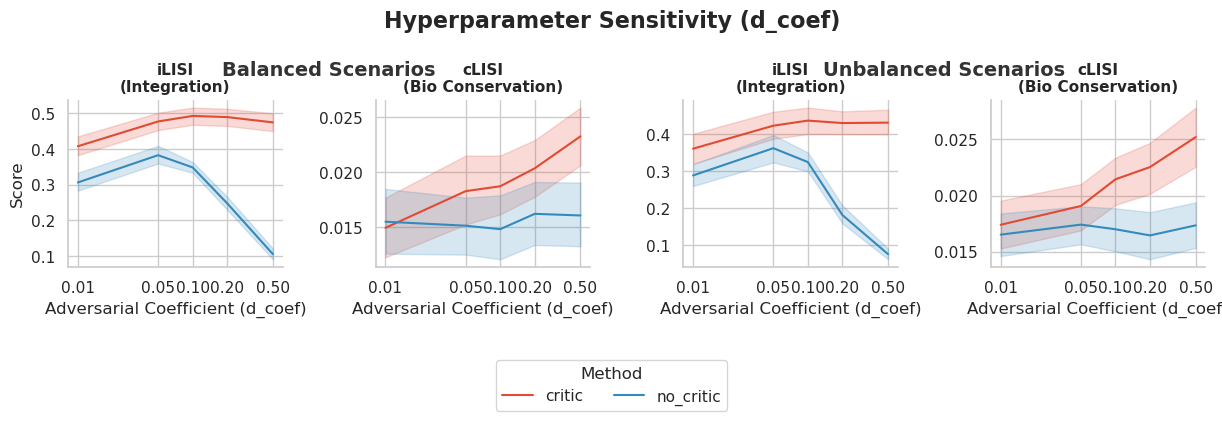

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import ScalarFormatter

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments"
data_frames = []

print(f"Scanning {base_dir} for sensitivity records...")

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("_comprehensive_sensitivity_records.csv"):
            file_path = os.path.join(root, file)
            parts = file_path.split(os.sep)
            
            try:
                # Path: .../condition/filename
                condition = parts[-2] # 'balanced' or 'unbalanced'
                
                # Filename: [dataset]_comprehensive_sensitivity_records.csv
                dataset_name_raw = file.split('_comprehensive')[0]
                
                if "immune" in dataset_name_raw: dataset_name = "Immune"
                elif "lung" in dataset_name_raw: dataset_name = "Lung"
                elif "panc" in dataset_name_raw: dataset_name = "Pancreas"
                else: dataset_name = "Unknown"

                df = pd.read_csv(file_path)
                
                # Filter for INNER VALIDATION data only
                # This represents the hyperparameter search phase
                df = df[df['data_type'] == 'inner_validation_raw'].copy()
                
                df['condition'] = condition.capitalize()
                df['dataset'] = dataset_name
                
                data_frames.append(df)
            except Exception as e:
                pass

if not data_frames:
    raise FileNotFoundError("No sensitivity records found.")

combined_df = pd.concat(data_frames, ignore_index=True)

# --- 2. Data Preparation ---
long_df = combined_df.melt(
    id_vars=['dataset', 'condition', 'd_coef', 'method', 'outer_fold', 'inner_fold'],
    value_vars=['ilisi', 'clisi'],
    var_name='metric_type',
    value_name='score'
)

metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# Create Panel Grouping
long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']

col_order = [
    f"Balanced\n{metric_renames['ilisi']}", 
    f"Balanced\n{metric_renames['clisi']}",
    f"Unbalanced\n{metric_renames['ilisi']}", 
    f"Unbalanced\n{metric_renames['clisi']}"
]

# --- 3. Plotting ---
sns.set_theme(style="whitegrid", font_scale=1.0)

g = sns.relplot(
    data=long_df,
    x="d_coef",
    y="score",
    hue="method",
    col="panel_group",
    col_order=col_order,
    kind="line",
    markers=True,
    dashes=False,
    errorbar=("ci", 95), # Shows variation across Datasets and Folds
    palette={"critic": "#E24A33", "no_critic": "#348ABD"},
    height=3.5,
    aspect=0.8,
    facet_kws={"sharey": False, "sharex": True}
)

# --- 4. Customization (Log Scale for d_coef) ---

# Set X-axis to Log Scale because d_coef values (0.01, 0.05, 0.1, ...) are logarithmic
g.set(xscale="log")

# clear titles
g.set_titles("")
g.set_axis_labels("Adversarial Coefficient (d_coef)", "Score")

# Fix X-Axis Ticks to match your specific grid search values
d_coef_values = [0.01, 0.05, 0.1, 0.2, 0.5]
for ax in g.axes.flatten():
    ax.set_xticks(d_coef_values)
    ax.get_xaxis().set_major_formatter(ScalarFormatter()) # No scientific notation (10^-2)
    ax.minorticks_off()

# Set Top Row Titles
clean_titles = [
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)", 
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)"
]
for ax, title in zip(g.axes[0], clean_titles):
    ax.set_title(title, fontweight='bold', fontsize=11)

# Group Subtitles
g.fig.tight_layout(rect=[0, 0.05, 1, 0.88]) 

def add_group_subtitle(g, col_indices, text, y_offset=0.06):
    ax_left = g.axes[0, col_indices[0]]
    ax_right = g.axes[0, col_indices[-1]]
    center_x = (ax_left.get_position().x0 + ax_right.get_position().x1) / 2
    center_y = ax_left.get_position().y1 + y_offset
    g.fig.text(center_x, center_y, text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

add_group_subtitle(g, [0, 1], "Balanced Scenarios")
add_group_subtitle(g, [2, 3], "Unbalanced Scenarios")

g.fig.suptitle("Hyperparameter Sensitivity (d_coef)", y=0.98, fontsize=16, fontweight='bold')
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.0), ncol=2, title="Method", frameon=True)

plt.savefig("d_coef_sensitivity.png", dpi=300, bbox_inches='tight')
plt.show()